# Here I fit the Curie-Weiss Law to the Magnetization vs Temeperature data as measured by the PPMS-VSM. 
If the Weiss constant is negative we have an antiferromagnet, if the Weiss constant is positive we have a ferromagnet.
We get the effective magnetic moment and g-factor from Curie's constant.

We typically look at two types of runs, Field Cooling (FC) and Zero-Field Cooling (ZFC).


In [37]:
import seaborn as sns
sns.set()
import sys
sys.path.append('..')
from JensenTools import *

## My functions

In [38]:
# This is the inverse of the Curie-Weiss Law.
# We will be creating an LMFIT model with this and fitting for:
## Curie's constant 'c', Weiss' constant 'wc'
def Curiei(t,c,wc):
    return(t-wc)/c

# Takes in Curie's constant and the system's total angular momentum J value
# Returns effective moment (bohr magnetons) and effective g-factor
def calcConstants(c,J):
    ueff = np.sqrt(8*c)
    gj = ueff/np.sqrt(J*(J+1))
    return ueff, gj

## Delcare important variables

In [39]:
# kwargs
#####################################################################################################################################################################
comp = 'Sr2PrO4'
who = 'Arun'
# comp = 'Li8PrO6'
# who = 'PPMS'
ion = 'Ce3+'
# massErr = .00005
molweight = molweight[comp]
per = 'mol'

# The L,S, J_eff values are as follows for the Pr4+ ion
L = 3
S = 0.5
J = 1/2
#####################################################################################################################################################################

## Load the M vs T data, normalize per mol, and choose either FC or ZFC

In [40]:
saveDir = getSaveDir('m',comp = comp) #General Directory for the project
MTDir = getSaveDir('m',comp = comp, dataType = 'MT') #MvsT data
    
# Loading data for M vs T 
#####################################################################################################################################################################
runs = []
for i in os.listdir(MTDir):
    if i.endswith('.DAT') or i.endswith('.dat'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)
MTdata = {}
for i in runs:
    M,H,T,MErr,mass,measType = getData(i,MTDir, who = who, dataType = 'MT')
    M = normalize(M,mass,molweight,per)
    MErr = normalize(MErr,mass,molweight,per)
    MTdata[measType] = [M,H,T,MErr,mass]

#Either 'ZFC' or 'FC'
M,H,T,MErr,mass = MTdata['ZFC']

## Calculate susceptibility / inverse susceptibility in both sets of units

In [41]:
X = M/H
Xi = 1/X

MBohr = emuToBohr2(M)
HTes = oeToTesla(H)

XBohr = MBohr / HTes
XBohrI = 1 / XBohr

# Chop data to range we desire.

In [42]:
tr = [0,300] #temprange = [low,high]
XTemp = []
XiTemp = []
XBohrTemp = []
XBohrITemp = []
TTemp = []
for i in range(len(T)):
    if (T[i] >= tr[0] and T[i]<= tr[1]):
        XTemp.append(X[i])
        XiTemp.append(Xi[i])
        XBohrTemp.append(XBohr[i])
        XBohrITemp.append(XBohrI[i])
        TTemp.append(T[i])
X = XTemp
Xi = XiTemp
XBohr = XBohrTemp
XBohrI = XBohrITemp
T = TTemp

## Choose a range of temperatures to fit over 'tr', create the LMFIT model, make an initial guess for 'c' and 'wc', fit over desired range, create a full line using the fitted parameters


In [43]:
tr = [200,300] #temprange = [low,high]

cmodeli =  Model(Curiei, independent_vars = ['t'])
params = cmodeli.make_params()
params['wc'].set(value = 10)
params['c'].set(value = 10)
newT = []
newXi = []
# newE = []
for i in range(len(T)):
    if (T[i] >= tr[0] and T[i]<= tr[1]):
        newT.append(T[i])
        newXi.append(Xi[i])
#         newE.append(XiErr[i])

resulti = cmodeli.fit(newXi, params, t = newT) #fit

fullLine = []
for i in T:
    fullLine.append(Curiei(i,resulti.params['c'].value,resulti.params['wc'].value))


## Plot the inverse suscptibility and the fit as well as calculated constants

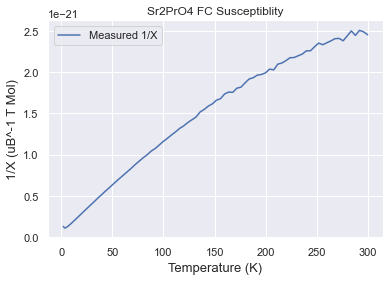

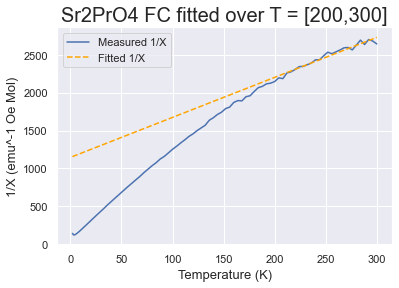

The Weiss constant = -216.53 K
The Curie constant = 0.189
Effective moment for Sr2PrO4 is 1.230 bohr magnetons, with J=0.5 -> gj factor = 1.420


In [44]:
plt.figure()
plt.plot(T,XBohrI,label = 'Measured 1/X')
plt.xlabel('Temperature (K)', fontsize = 13)
plt.ylabel('1/X (uB^-1 T Mol)', fontsize = 13)
plt.title('{} {} Susceptiblity'.format(comp,measType))
plt.legend()
plt.show()

plt.figure()
plt.plot(T,Xi,label = 'Measured 1/X')
plt.plot(T,fullLine,'orange', linestyle = '--', label = 'Fitted 1/X')
plt.title("{} {} fitted over T = [{},{}]".format(comp,measType,tr[0],tr[1]), fontsize = 20)
plt.xlabel('Temperature (K)', fontsize = 13)
plt.ylabel('1/X (emu^-1 Oe Mol)', fontsize = 13)
plt.legend()
plt.show()


print('The Weiss constant = {:.2f} K\nThe Curie constant = {:.3f}'.format(resulti.params['wc'].value,resulti.params['c'].value))

J = 1/2
ueff, gj = calcConstants(resulti.params['c'].value,J)

# print(ueff/(mass/molweight)*6.02*10**-23)
print('Effective moment for {:} is {:.3f} bohr magnetons, with J={} -> gj factor = {:.3f}'.format(comp,ueff,J,gj))